# __Ocean regimes indicator__

Apply a Gaussian Mixtures Model to a dataset of time series

***
ds : initial dataset (lat, lon, week)

X : staked dataset (sampling, week, week_reduced)

X_labels: unstacked final dataset (lat, lon, week)
***

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib as mpl

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

## Load dataset
***

One year of SST data in the Mediterranean Sea:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [2]:
file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1607013925530.nc'

One year of SST data in the North Atlantic:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [3]:
file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1608215256580.nc'

Open dataset

In [4]:
ds = xr.open_dataset(file_path)
print(ds)
#ds

<xarray.Dataset>
Dimensions:                                        (lat: 69, lon: 40, time: 8760)
Coordinates:
  * time                                           (time) datetime64[ns] 2019-01-01T00:30:00 ... 2019-12-31T23:30:00
  * lat                                            (lat) float32 25.125 ... 42.125
  * lon                                            (lon) float32 -54.875 ... -45.125
Data variables:
    sea_surface_warm_layer_temperature_difference  (time, lat, lon) float32 ...
    sea_surface_cool_skin_temperature_difference   (time, lat, lon) float32 ...
    sea_ice_fraction                               (time, lat, lon) float32 ...
    analysed_sst                                   (time, lat, lon) float32 ...
    mask                                           (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      Global Diurnal Skin SST Analysis, L4 OSTIA, 0...
    summary:                    A merged, multi-sensor 

__Quick plot__

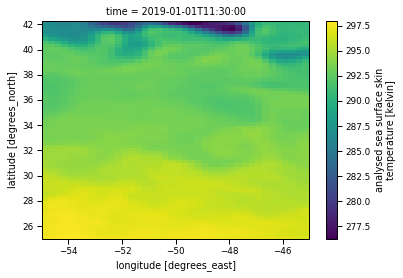

In [5]:
ds['analysed_sst'].isel(time=11).plot();

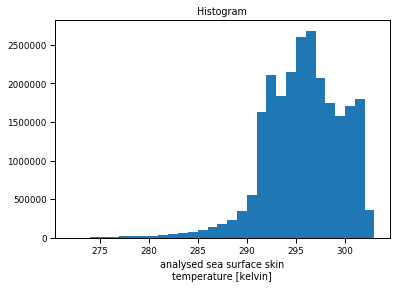

In [6]:
bins = np.arange(int(ds['analysed_sst'].min().values), int(ds['analysed_sst'].max().values))
ds['analysed_sst'].plot.hist(bins=bins);

## Preprocessing
***

#### __1) Weekly mean for each pixel__

In [7]:
ds = ds.groupby("time.week").mean()
print(ds)
#ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values


<xarray.Dataset>
Dimensions:                                        (lat: 69, lon: 40, week: 52)
Coordinates:
  * lat                                            (lat) float32 25.125 ... 42.125
  * lon                                            (lon) float32 -54.875 ... -45.125
  * week                                           (week) int64 1 2 3 ... 51 52
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, lat, lon) float32 0.03133854 ... -0.022535713
    sea_surface_cool_skin_temperature_difference   (week, lat, lon) float32 -0.3995366 ... -0.32082748
    sea_ice_fraction                               (week, lat, lon) float32 0.0 ... 0.0
    analysed_sst                                   (week, lat, lon) float32 297.383 ... 290.5489
    mask                                           (week, lat, lon) float32 1.0 ... 1.0


Plot histogram in time

Text(0, 0.5, 'Counts')

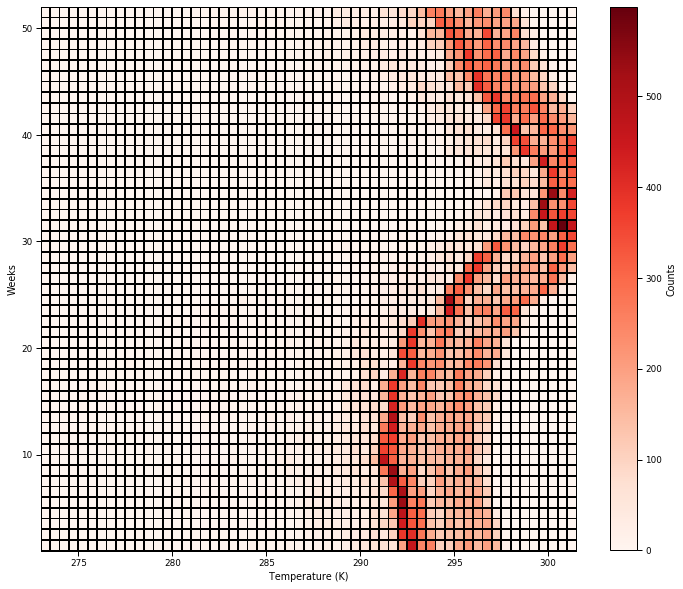

In [8]:
bins = np.arange(int(ds['analysed_sst'].min().values), int(ds['analysed_sst'].max().values),0.5)
histo_2d = [] 
for iweek in range(52):
    hist_values, bin_edges = np.histogram(ds['analysed_sst'].isel(week=iweek).values, bins=bins)
    histo_2d.append(hist_values)
    
fig, ax = plt.subplots(figsize=(12,10))
plt.pcolormesh(bins, ds.week.values, histo_2d, cmap='Reds', edgecolors='black')
cbar = plt.colorbar()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Weeks')
cbar.ax.set_ylabel('Counts')

#### __2) Reduce lat lon dimensions to sampling dimension__

In [9]:
sampling_dims = list(ds.dims)
sampling_dims.remove('week')
sampling_dims

['lat', 'lon']

In [10]:
X = ds.stack({'sampling': sampling_dims})
#X = X.rename_dims({'week': 'feature'})
print(X)
#X

<xarray.Dataset>
Dimensions:                                        (sampling: 2760, week: 52)
Coordinates:
  * week                                           (week) int64 1 2 3 ... 51 52
  * sampling                                       (sampling) MultiIndex
  - lat                                            (sampling) float64 25.12 ... 42.12
  - lon                                            (sampling) float64 -54.88 ... -45.12
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, sampling) float32 0.03133854 ... -0.022535713
    sea_surface_cool_skin_temperature_difference   (week, sampling) float32 -0.3995366 ... -0.32082748
    sea_ice_fraction                               (week, sampling) float32 0.0 ... 0.0
    analysed_sst                                   (week, sampling) float32 297.383 ... 290.5489
    mask                                           (week, sampling) float32 1.0 ... 1.0


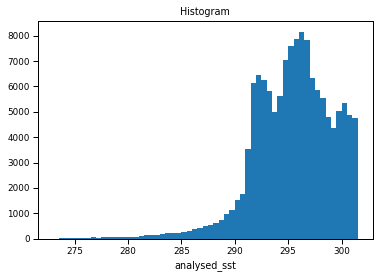

In [11]:
X['analysed_sst'].plot.hist(bins=bins);

#### __3) Delate all NaN time series using mask__

Plot mask (water = 1)

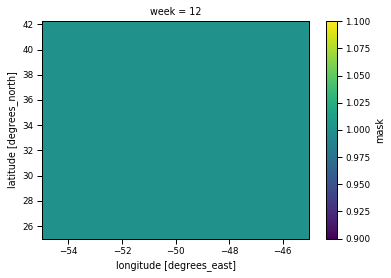

In [12]:
ds['mask'].isel(week=11).plot();

In [13]:
stacked_mask = X['mask']
print(stacked_mask)
#stacked_mask

<xarray.DataArray 'mask' (week: 52, sampling: 2760)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * week      (week) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52
  * sampling  (sampling) MultiIndex
  - lat       (sampling) float64 25.12 25.12 25.12 25.12 ... 42.12 42.12 42.12
  - lon       (sampling) float64 -54.88 -54.62 -54.38 ... -45.62 -45.38 -45.12


In [14]:
X = X['analysed_sst'].where(stacked_mask == 1, drop=True).to_dataset()
print(X)
#X

<xarray.Dataset>
Dimensions:       (sampling: 2760, week: 52)
Coordinates:
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12 42.12
  - lon           (sampling) float64 -54.88 -54.62 -54.38 ... -45.38 -45.12
Data variables:
    analysed_sst  (week, sampling) float32 297.383 297.49167 ... 290.5489


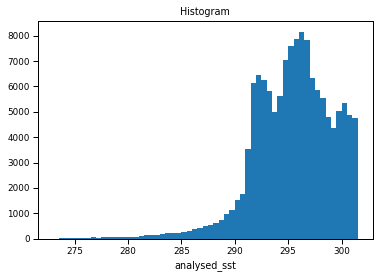

In [15]:
X['analysed_sst'].plot.hist(bins=bins);

Recover the dataset (unravel)

In [16]:
sampling_dims.append('week')
coords = list()
size = list()
for dim in sampling_dims:
    coords.append(ds[dim])
    size.append(len(ds[dim]))
    
X_unstacked = xr.DataArray(np.empty((size)), coords=coords)
sampling_dims.remove('week')
X_unstacked = X_unstacked.stack({'sampling': sampling_dims})
X_unstacked = X_unstacked.where(stacked_mask == 1, drop=True)
X_unstacked.values = X['analysed_sst']
X_unstacked = X_unstacked.unstack('sampling').to_dataset(name = 'analysed_sst')
X_unstacked = X_unstacked.sortby(['lat','lon'])

X_unstacked 

<xarray.Dataset>
Dimensions:       (lat: 69, lon: 40, week: 52)
Coordinates:
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * lat           (lat) float64 25.12 25.38 25.62 25.88 ... 41.62 41.88 42.12
  * lon           (lon) float64 -54.88 -54.62 -54.38 ... -45.62 -45.38 -45.12
Data variables:
    analysed_sst  (week, lat, lon) float32 297.383 297.49167 ... 290.5489

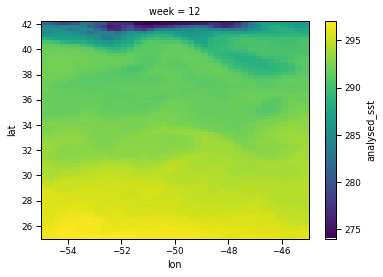

In [17]:
X_unstacked['analysed_sst'].isel(week=11).plot();

__There is any NaN in the dataset?__

In [18]:
np.any(np.isnan(X['analysed_sst'].values))

False

#### __4) Interpolation__

In [19]:
X = X['analysed_sst'].interpolate_na(dim = 'week', method="linear", fill_value="extrapolate").to_dataset(name = 'analysed_sst')
print(X)
#X

<xarray.Dataset>
Dimensions:       (sampling: 2760, week: 52)
Coordinates:
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12 42.12
  - lon           (sampling) float64 -54.88 -54.62 -54.38 ... -45.38 -45.12
Data variables:
    analysed_sst  (week, sampling) float32 297.383 297.49167 ... 290.5489


__There is any NaN in the dataset?__

In [20]:
np.any(np.isnan(X['analysed_sst'].values))

False

#### __5) Scaler__

__Check dimensions order__
***

In [21]:
np.shape(X['analysed_sst'])

(52, 2760)

Transpose dataset if needed (sampling x features)

In [22]:
X = X.transpose("sampling", "week")
np.shape(X['analysed_sst'].values)

(2760, 52)

***

Apply sklearn __StandardScaler__: 
Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as:

    z = (x - u) / s
    
where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 

In [23]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X['analysed_sst'])
X = X.assign(variables={"analysed_sst_scaled":(('sampling', 'week'), X_scale)})
print(X)
#X

<xarray.Dataset>
Dimensions:              (sampling: 2760, week: 52)
Coordinates:
  * week                 (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * sampling             (sampling) MultiIndex
  - lat                  (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12
  - lon                  (sampling) float64 -54.88 -54.62 ... -45.38 -45.12
Data variables:
    analysed_sst         (sampling, week) float32 297.383 297.5014 ... 290.5489
    analysed_sst_scaled  (sampling, week) float32 1.3778889 ... -1.1244959


#### __5) PCA__

__Check dimensions order__
***

In [24]:
np.shape(X['analysed_sst_scaled'])

(2760, 52)

Transpose dataset if needed (sampling x features)

In [25]:
X = X.transpose("sampling", "week")
np.shape(X['analysed_sst_scaled'].values)

(2760, 52)

***

Apply __Principal component analysis__ (PCA):
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99, svd_solver = 'full')
pca

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [27]:
pca = pca.fit(X['analysed_sst_scaled'])

Text(0.5, 1.0, 'Percentage of variance explained by each of the selected components')

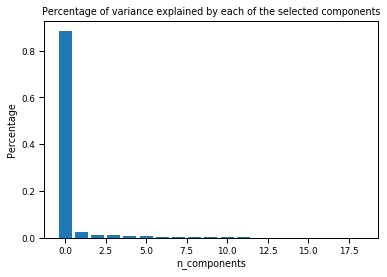

In [28]:
fig, ax = plt.subplots()
pb = plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
ax.set_xlabel('n_components')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of variance explained by each of the selected components')

In [29]:
X_reduced = pca.transform(X['analysed_sst_scaled'])
np.shape(X_reduced)

(2760, 19)

In [30]:
X = X.assign(variables={"analysed_sst_reduced":(('sampling', 'week_reduced'),X_reduced)})
print(X)

<xarray.Dataset>
Dimensions:               (sampling: 2760, week: 52, week_reduced: 19)
Coordinates:
  * week                  (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12
  - lon                   (sampling) float64 -54.88 -54.62 ... -45.38 -45.12
Dimensions without coordinates: week_reduced
Data variables:
    analysed_sst          (sampling, week) float32 297.383 297.5014 ... 290.5489
    analysed_sst_scaled   (sampling, week) float32 1.3778889 ... -1.1244959
    analysed_sst_reduced  (sampling, week_reduced) float32 -9.745885 ... -0.351675


## Apply Model
***

__Check dimensions order__
***

In [31]:
np.shape(X['analysed_sst_reduced'])

(2760, 19)

Transpose dataset if needed (sampling x features)

In [32]:
X = X.transpose("sampling", "week", "week_reduced")
np.shape(X['analysed_sst_reduced'].values)

(2760, 19)

***

__Create model__

In [33]:
from sklearn import mixture
k = 8 # number of classes
model = mixture.GaussianMixture(n_components=k, covariance_type='full')
model

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

__Fit model__

In [34]:
model.fit(X['analysed_sst_reduced'])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

__Predict labels__

In [35]:
X_labels = model.predict(X['analysed_sst_reduced'])
X_labels

array([2, 2, 2, ..., 1, 1, 1])

In [36]:
print(X_labels.min())
print(X_labels.max())

0
7


In [37]:
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})
print(X)
#X

<xarray.Dataset>
Dimensions:               (sampling: 2760, week: 52, week_reduced: 19)
Coordinates:
  * week                  (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12
  - lon                   (sampling) float64 -54.88 -54.62 ... -45.38 -45.12
Dimensions without coordinates: week_reduced
Data variables:
    analysed_sst          (sampling, week) float32 297.383 297.5014 ... 290.5489
    analysed_sst_scaled   (sampling, week) float32 1.3778889 ... -1.1244959
    analysed_sst_reduced  (sampling, week_reduced) float32 -9.745885 ... -0.351675
    GMM_labels            (sampling) int64 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1


Calculate other __stadistics__

- Predict posterior probability of each component given the data

In [38]:
X_proba = model.predict_proba(X['analysed_sst_reduced'])
np.shape(X_proba)

(2760, 8)

In [39]:
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})
print(X)
#X

<xarray.Dataset>
Dimensions:               (k: 8, sampling: 2760, week: 52, week_reduced: 19)
Coordinates:
  * week                  (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12
  - lon                   (sampling) float64 -54.88 -54.62 ... -45.38 -45.12
Dimensions without coordinates: k, week_reduced
Data variables:
    analysed_sst          (sampling, week) float32 297.383 297.5014 ... 290.5489
    analysed_sst_scaled   (sampling, week) float32 1.3778889 ... -1.1244959
    analysed_sst_reduced  (sampling, week_reduced) float32 -9.745885 ... -0.351675
    GMM_labels            (sampling) int64 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
    GMM_post              (sampling, k) float64 1.952e-162 ... 3.666e-22


- Calculate quantiles

In [41]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [62]:
m_quantiles = X['analysed_sst'].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X['analysed_sst'].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [68]:
X = X.assign(variables={"analysed_sst_Q":(('k','quantiles','week'), m_quantiles)})
print(X)

<xarray.Dataset>
Dimensions:               (k: 8, quantiles: 3, sampling: 2760, week: 52, week_reduced: 19)
Coordinates:
  * week                  (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12
  - lon                   (sampling) float64 -54.88 -54.62 ... -45.38 -45.12
Dimensions without coordinates: k, quantiles, week_reduced
Data variables:
    analysed_sst          (sampling, week) float32 297.383 297.5014 ... 290.5489
    analysed_sst_scaled   (sampling, week) float32 1.3778889 ... -1.1244959
    analysed_sst_reduced  (sampling, week_reduced) float32 -9.745885 ... -0.351675
    GMM_labels            (sampling) int64 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
    GMM_post              (sampling, k) float64 1.952e-162 ... 3.666e-22
    analysed_sst_Q        (k, quantiles, week) float64 293.0 292.7 ... 291.8
    GMM_robustness        (sampling) float64 1.0 

- Calculate robustness

In [47]:
maxpost = X["GMM_post"].max(dim="k")
K = len(X["GMM_labels"])
robust = (maxpost - 1. / K) * K / (K - 1.)

Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

In [48]:
X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0
print(X)
#X

<xarray.Dataset>
Dimensions:               (k: 8, quantiles: 3, sampling: 2760, week: 52, week_reduced: 19)
Coordinates:
  * week                  (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 25.12 25.12 25.12 ... 42.12 42.12
  - lon                   (sampling) float64 -54.88 -54.62 ... -45.38 -45.12
Dimensions without coordinates: k, quantiles, week_reduced
Data variables:
    analysed_sst          (sampling, week) float32 297.383 297.5014 ... 290.5489
    analysed_sst_scaled   (sampling, week) float32 1.3778889 ... -1.1244959
    analysed_sst_reduced  (sampling, week_reduced) float32 -9.745885 ... -0.351675
    GMM_labels            (sampling) int64 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
    GMM_post              (sampling, k) float64 1.952e-162 ... 3.666e-22
    analysed_sst_Q        (quantiles, week) float64 282.9 281.4 ... 292.8 291.8
    GMM_robustness        (sampling) float64 1

__Unstack dataset__

In [66]:
ds_labels = X.unstack('sampling')
ds_labels = ds_labels.sortby(['lat','lon'])
print(ds_labels)
#ds_labels

<xarray.Dataset>
Dimensions:               (k: 8, lat: 69, lon: 40, quantiles: 3, week: 52, week_reduced: 19)
Coordinates:
  * week                  (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * lat                   (lat) float64 25.12 25.38 25.62 ... 41.62 41.88 42.12
  * lon                   (lon) float64 -54.88 -54.62 -54.38 ... -45.38 -45.12
Dimensions without coordinates: k, quantiles, week_reduced
Data variables:
    analysed_sst          (week, lat, lon) float32 297.383 ... 290.5489
    analysed_sst_scaled   (week, lat, lon) float32 1.3778889 ... -1.1244959
    analysed_sst_reduced  (week_reduced, lat, lon) float32 -9.745885 ... -0.351675
    GMM_labels            (lat, lon) int64 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
    GMM_post              (k, lat, lon) float64 1.952e-162 ... 3.666e-22
    analysed_sst_Q        (k, quantiles, week) float64 293.0 292.7 ... 291.8
    GMM_robustness        (lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    GMM_robustness_c

## Plot results
***

#### __1) Mean time series__

Mean and stardard deviation (change to quantiles)

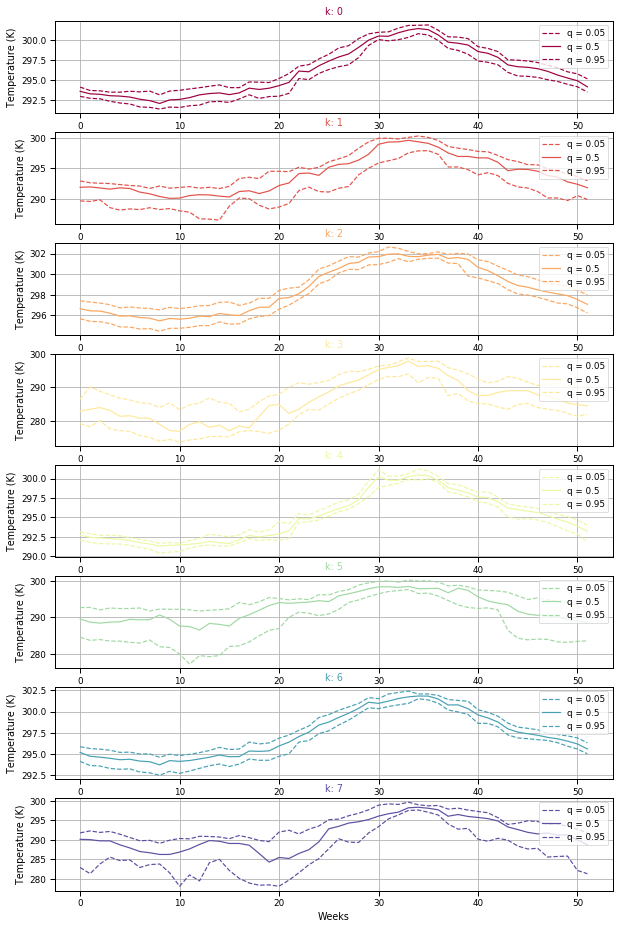

In [69]:
line_style = ['--','-','--']
cmap=plt.cm.get_cmap('Spectral', k)
fig, ax = plt.subplots(nrows=k, ncols=1, figsize=(10,16))

for ik in range(k):
    ax[ik].grid()
    for iq in range(np.size(q)):
        ax[ik].plot(ds_labels['analysed_sst_Q'].isel(quantiles=iq, k=ik), line_style[iq], color=cmap(ik),  label = 'q = '+ str(q[iq]))
    ax[ik].set_xlabel('Weeks')
    ax[ik].set_ylabel('Temperature (K)')
    ax[ik].set_title(("k: %i") % (ik), color=cmap(ik))
    ax[ik].legend(loc='upper right')

All mean time series in the same plot 

In [ ]:
cmap=plt.cm.get_cmap('Spectral', k)
fig = plt.figure(figsize=(20,6))
plt.gca().set_facecolor('grey')
plt.grid()
for yi in range(k):
    plt.plot(X['analysed_sst'].where(X['GMM_labels']==yi, drop=True).mean('sampling'),color=cmap(yi))

norm = mpl.colors.Normalize(vmin=0,vmax=k-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(k)) 
plt.gca().set_xlabel('Weeks')
plt.gca().set_ylabel('Temperature (K)')
plt.gca().set_title("Median time series")
plt.show()

Temperature is normalized

In [ ]:
cmap=plt.cm.get_cmap('Spectral', k)
plt.figure(figsize=(20,6))
plt.gca().set_facecolor('grey')
plt.grid()
for yi in range(k):
    plt.plot(X['analysed_sst_scaled'].where(X['GMM_labels']==yi, drop=True).mean('sampling'),color=cmap(yi))

norm = mpl.colors.Normalize(vmin=0,vmax=k-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(k))
plt.gca().set_xlabel('Weeks')
plt.gca().set_ylabel('Normalized temperature (K)')
plt.gca().set_title("Median time series")
plt.show()

#### __2) Spatial distribution of classes__

In [ ]:
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='10m',facecolor='grey')
map_extent = [ds_labels['lon'].values.min()-1, ds_labels['lon'].values.max()+1, ds_labels['lat'].values.min()-1, ds_labels['lat'].values.max()+1]
fig=plt.figure(figsize=(18,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(land_feature, edgecolor='black')
ax.set_extent(map_extent, crs=ccrs.PlateCarree())
plt.pcolormesh(ds_labels['lon'], ds_labels['lat'], ds_labels['GMM_labels'], vmin=0, vmax=k-1, cmap=plt.cm.get_cmap('Spectral', k))
plt.colorbar(ticks=range(k),fraction=0.016, pad=0.04)
#plt.clim([-0.5,4.5])
plt.show()

#### __3) Robustness__

In [ ]:
title_string = '$\\bf{GMM\\  Robustness}$' + ' \n probability of a profile to belong to a class k'
extent = np.array([min(ds_labels['lon']), max(ds_labels['lon']), min(ds_labels['lat']), max(ds_labels['lat'])] + np.array([-0.1, +0.1, -0.1, +0.1]))

#subplot_kw = {'projection': ccrs.PlateCarree(), 'extent': extent}
#land_feature = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
lon_grid = np.floor_divide((ds_labels['lon'].max() - ds_labels['lon'].min()), 5)
lat_grid = np.floor_divide((ds_labels['lat'].max() - ds_labels['lat'].min()), 5)

maxcols = 2
ar = 1.0  # initial aspect ratio for first trial
wi = 10    # width of the whole figure in inches
hi = wi * ar  # height in inches
rows, cols = 1 + np.int(k / maxcols), maxcols

fig, ax = plt.subplots(figsize=(wi, hi), nrows=k, ncols=1, facecolor='w', edgecolor='k', dpi=120, subplot_kw={'projection': ccrs.PlateCarree(), 'extent': extent})
#plt.subplots_adjust(wspace=0.2, hspace=0.4)
#plt.rcParams['figure.constrained_layout.use'] = True

cmap=plt.cm.get_cmap('Spectral', k)

for i in range(1):
#for i in range(k):
    
    ax[i].add_feature(land_feature, edgecolor='black')
    ax[i].set_extent(map_extent, crs=ccrs.PlateCarree())
    sc = ax[i].pcolormesh(ds_labels['lon'], ds_labels['lat'], ds_labels['GMM_robustness_cat'].where(ds_labels['GMM_labels'] == k),
                            cmap=cmap, transform=ccrs.PlateCarree(), vmin=0, vmax=5)

    #self.m.plot.latlongrid(ax[k], fontsize=6, dx=lon_grid, dy=lat_grid)
    #ax[k].add_feature(land_feature, edgecolor='black')
    #ax[k].set_title('k=%i' % k, color=kmap(k), fontweight='bold', x=1.05, y=0.84)
    #ax[k].set_title('k=%i' % k, color=kmap(k), fontweight='bold')

# aspect ratio
#plt.draw()
#xmin, xmax = ax[0].get_xbound()
#ymin, ymax = ax[0].get_ybound()
#y2x_ratio = (ymax-ymin)/(xmax-xmin) * rows/cols
#fig.set_figheight(wi * y2x_ratio)
        #print(wi * y2x_ratio)
        # fig.subplots_adjust(top=0.90)
        # fig.tight_layout()
        #fig.tight_layout(rect=[0, 0, 1, 0.90])

#fig.subplots_adjust(top=0.90)
        #plt.subplots_adjust(wspace = 0.2, hspace=0.4)
#fig.suptitle(title_string, fontsize=10)

        # plt.subplots_adjust(hspace=0.3)
        #plt.subplots_adjust(wspace = 0.2, hspace=0.4)

        #boundaries = dsp['PCM_ROBUSTNESS_CAT'].attrs['bins']
rowl0 = ds_labels['GMM_robustness_cat'].attrs['legend']
        #cl = fig.colorbar(sc, ax=ax.ravel().tolist(),fraction=0.02)
cl = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.05)
cl.set_ticks([0,1,2,3,4,5])
cl.set_ticklabels([0,0.33,0.66,0.9,0.99,1])
for (i, j) in zip(np.arange(0.5, 5, 1), rowl0):
        cl.ax.text(6, i, j, ha='left', va='center', fontsize=8)

        # fig.canvas.draw()
        # fig.tight_layout()
        # fig.subplots_adjust(top=0.95)
#plt.rcParams['figure.constrained_layout.use'] = False


In [ ]:
ds_labels['GMM_robustness_cat'].where(ds_labels['GMM_labels'] == k)

#### __4) Classes pie chart__

In [ ]:
pcm_labels = ds_labels['GMM_labels']
cmap=plt.cm.get_cmap('Spectral', k)

for cl in range(k):
    # get labels
    pcm_labels_k = pcm_labels.where(pcm_labels == cl)
    if cl == 0:
        counts_k = pcm_labels_k.count(...)
        pie_labels = list(['K=%i' % cl])
        table_cn = list([[str(cl), str(counts_k.values)]])
    else:
        counts_k = xr.concat([counts_k, pcm_labels_k.count(...)], "k")
        pie_labels.append('K=%i' % cl)
        table_cn.append([str(cl), str(counts_k[cl].values)])

table_cn.append(['Total', str(sum([int(row[1]) for row in table_cn]))])

fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
# fig.set_cmap(kmap)

cheader = ['$\\bf{K}$', '$\\bf{Number\\ of\\ profiles}$']
ccolors = plt.cm.BuPu(np.full(len(cheader), 0.1))
the_table = plt.table(cellText=table_cn, cellLoc='center', loc='center',
                        colLabels=cheader, colColours=ccolors, fontsize=14, colWidths=(0.2, 0.45))

the_table.auto_set_font_size(False)
the_table.set_fontsize(12)

explode = np.ones(k)*0.05
kmap_n = [list(cmap(i)[0:3]) for i in range(k)]
textprops = {'fontweight': "bold", 'fontsize': 12}

_, _, autotexts = ax[0].pie(counts_k, labels=pie_labels, autopct='%1.1f%%',
                            startangle=90, colors=kmap_n, explode=explode, textprops=textprops, pctdistance=0.5)

#labels in white
for autotext in autotexts:
    autotext.set_fontweight('normal')
    autotext.set_fontsize(10)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
ax[0].add_artist(centre_circle)
# fig.gca().add_artist(centre_circle)

ax[0].axis('equal')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.box(on=None)
the_table.scale(1, 1.5)
fig.suptitle('$\\bf{Classes\\ distribution}$', fontsize=14)
plt.tight_layout()
